In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [75]:
# Load the datasets

DATASET_TRAIN = 'train.csv'
DATASET_TEST = 'test.csv'

current_dir = os.getcwd()
csv_path_train = os.path.join(current_dir, '..', '..', 'data', DATASET_TRAIN)
csv_path_test = os.path.join(current_dir, '..', '..', 'data', DATASET_TRAIN)

train_df = pd.read_csv(csv_path_train)
test_df = pd.read_csv(csv_path_test)

In [76]:
# Create all the features for both datasets (assuming we've already defined these functions)
# Copy the feature creation code for both datasets

# For train_df:
# 1. Age binning
age_bins = [0, 5, 10, 20, 30, 40, 50, 60, 80]
age_labels = ['0-5', '6-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-80']
train_df['Age_Group'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels)
test_df['Age_Group'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels)

# 2. Cabin letter
train_df['Cabin_Letter'] = train_df['Cabin'].str[0]
train_df['Cabin_Letter'].fillna('U', inplace=True)
test_df['Cabin_Letter'] = test_df['Cabin'].str[0]
test_df['Cabin_Letter'].fillna('U', inplace=True)

# 3. Parent feature
train_df['Parent'] = ((train_df['SibSp'] == 1) & (train_df['Parch'] > 0)).astype(int)
test_df['Parent'] = ((test_df['SibSp'] == 1) & (test_df['Parch'] > 0)).astype(int)

# 4. Sex-Age interaction
train_df['Sex_Age'] = train_df['Sex'] + '_' + train_df['Age_Group'].astype(str)
test_df['Sex_Age'] = test_df['Sex'] + '_' + test_df['Age_Group'].astype(str)

# 5. Total family size
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1

# 6. Title extraction
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.')
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.')

# Group uncommon titles
def replace_titles(x):
    title = x['Title']
    if title in ['Mr', 'Mrs', 'Miss', 'Master']:
        return title
    elif title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Sir'
    elif title in ['Countess', 'Mme', 'Lady']:
        return 'Lady'
    elif title in ['Ms', 'Mlle']:
        return 'Miss'
    else:
        return 'Other'

train_df['Title'] = train_df.apply(replace_titles, axis=1)
test_df['Title'] = test_df.apply(replace_titles, axis=1)

# 7. Number of people sharing the same ticket
ticket_counts_train = train_df['Ticket'].value_counts()
train_df['Ticket_Count'] = train_df['Ticket'].map(ticket_counts_train)

# For test tickets, some might not be in training set
ticket_counts_test = test_df['Ticket'].value_counts()
all_tickets = pd.concat([train_df['Ticket'], test_df['Ticket']]).value_counts()
test_df['Ticket_Count'] = test_df['Ticket'].map(all_tickets)

# 8. Missing value in Cabin
train_df['Cabin_Missing'] = train_df['Cabin'].isna().astype(int)
test_df['Cabin_Missing'] = test_df['Cabin'].isna().astype(int)

# 9. Missing value in Age
train_df['Age_Missing'] = train_df['Age'].isna().astype(int)
test_df['Age_Missing'] = test_df['Age'].isna().astype(int)

# 10. Fare per person
train_df['Fare_Per_Person'] = train_df['Fare'] / train_df['Ticket_Count']
train_df['Fare_Per_Person'].fillna(train_df['Fare'], inplace=True)
test_df['Fare_Per_Person'] = test_df['Fare'] / test_df['Ticket_Count']
test_df['Fare_Per_Person'].fillna(test_df['Fare'], inplace=True)

# 11. Fare binning
fare_per_person_bins = [0, 7, 10, 15, 25, 40, 100, train_df['Fare_Per_Person'].max()]
train_df['Fare_Per_Person_Range'] = pd.cut(train_df['Fare_Per_Person'], bins=fare_per_person_bins)
test_df['Fare_Per_Person_Range'] = pd.cut(test_df['Fare_Per_Person'], bins=fare_per_person_bins)
train_df['Fare_Per_Person_Range'] = train_df['Fare_Per_Person_Range'].astype(str)
test_df['Fare_Per_Person_Range'] = test_df['Fare_Per_Person_Range'].astype(str)

<>:30: SyntaxWarning: invalid escape sequence '\.'
<>:31: SyntaxWarning: invalid escape sequence '\.'
<>:30: SyntaxWarning: invalid escape sequence '\.'
<>:31: SyntaxWarning: invalid escape sequence '\.'
C:\Users\willi\AppData\Local\Temp\ipykernel_5388\3521883963.py:30: SyntaxWarning: invalid escape sequence '\.'
  train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.')
C:\Users\willi\AppData\Local\Temp\ipykernel_5388\3521883963.py:31: SyntaxWarning: invalid escape sequence '\.'
  test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.')
C:\Users\willi\AppData\Local\Temp\ipykernel_5388\3521883963.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [78]:
numerical_cols = ['Age', 'Fare_Per_Person', 'Family_Size']

def add_polynomial_features(df):
    # Handle missing values first
    imputer = SimpleImputer(strategy='mean')
    numerical_data_imputed = imputer.fit_transform(df[numerical_cols])
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(numerical_data_imputed)
    
    # Get feature names
    poly_feature_names = poly.get_feature_names_out(numerical_cols)
    
    # Create DataFrame with polynomial features
    poly_df = pd.DataFrame(
        poly_features, 
        columns=poly_feature_names,
        index=df.index
    )
    
    # Combine with original DataFrame
    return pd.concat([df, poly_df], axis=1)

# Apply to both datasets
train_df = add_polynomial_features(train_df)
test_df = add_polynomial_features(test_df)

pandas.core.frame.DataFrame

In [65]:
# Select features for the model
features = ['Pclass', 'Sex', 'Fare_Per_Person_Range', 
            'Embarked', 'Cabin_Letter', 'Family_Size', 
            'Title', 'Age_Missing', 'Sex_Age', 'Parent', 'Age^2']

# Define categorical and numerical features
categorical_features = ['Pclass', 'Sex', 'Fare_Per_Person_Range', 
                        'Embarked', 'Cabin_Letter', 'Title', 'Sex_Age', 'Parent']
numerical_features = ['Family_Size', 'Age_Missing', 'Age^2']


# To remove
# Parent, Cabin_Missing, Fare_Per_Person_Range, Age_Group, Ticket_Count

In [66]:
# Create X (features) and y (target) for training
X_train = train_df[features]
y_train = train_df['Survived']

# Create X for testing (note: test_df might not have the Survived column)
X_test = test_df[features]

# Create preprocessing pipelines for categorical and numerical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

# Create the modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on training data
train_score = model.score(X_train, y_train)
print(f"Training accuracy: {train_score:.4f}")



ValueError: Selected columns, ['Family_Size', 'Age_Missing', 'Age^2'], are not unique in dataframe

Testing accuracy: 0.8249

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       549
           1       0.89      0.62      0.73       342

    accuracy                           0.82       891
   macro avg       0.85      0.79      0.80       891
weighted avg       0.84      0.82      0.82       891



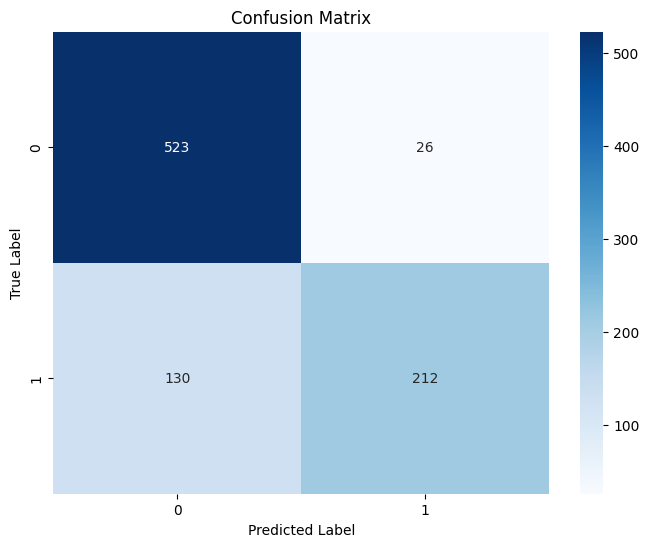

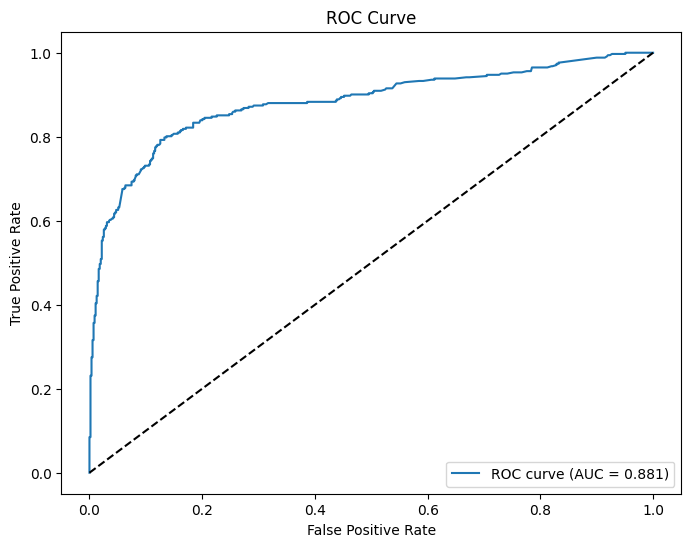

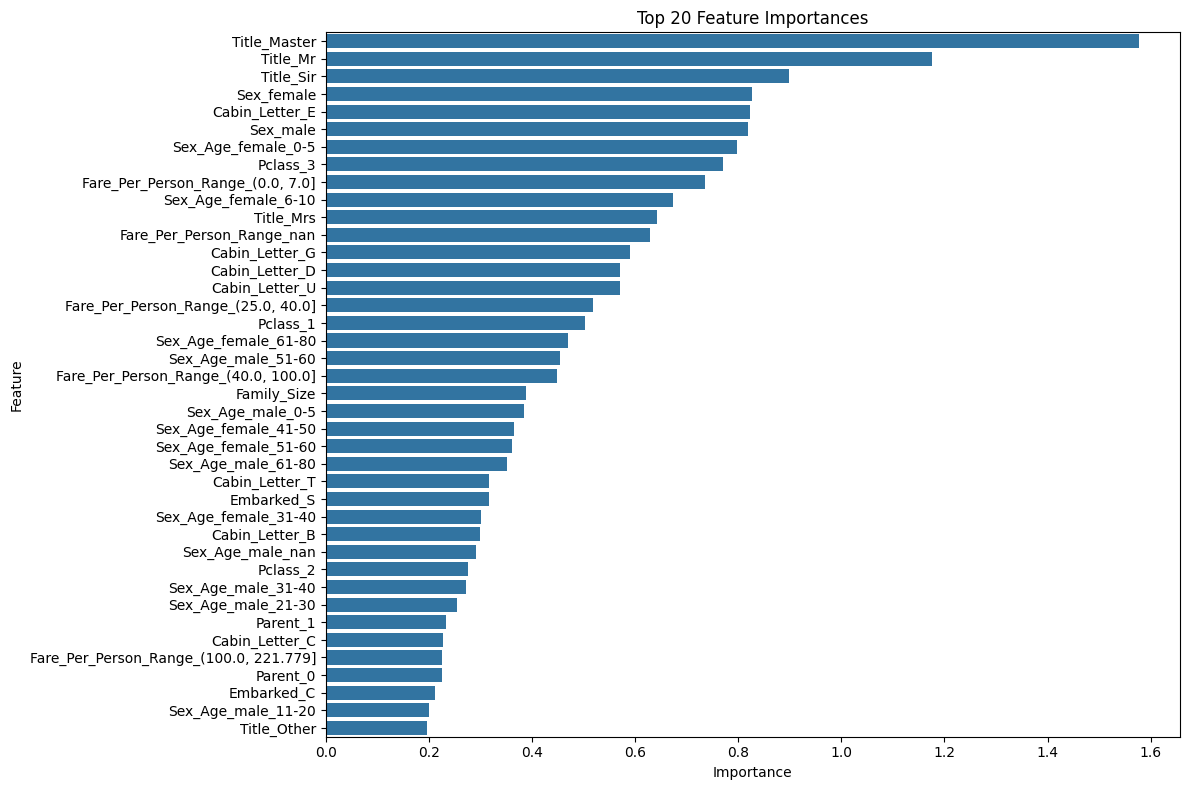

In [59]:
# Make predictions on the test set
if 'Survived' in test_df.columns:
    # If test set has labels (sometimes Kaggle gives these separately)
    y_test = test_df['Survived']
    y_pred = model.predict(X_test)
    test_score = model.score(X_test, y_test)
    print(f"Testing accuracy: {test_score:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Plot ROC curve
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    # If test set doesn't have labels (typical Kaggle competition format)
    y_pred = model.predict(X_test)
    test_df['Survived'] = y_pred
    
    # Create a submission file
    submission = test_df[['PassengerId', 'Survived']]
    submission.to_csv('glm_submission.csv', index=False)
    print("Predictions saved to 'glm_submission.csv'")

# Extract feature importances (coefficients)
feature_names = model.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = np.append(feature_names, numerical_features)
coefficients = model.named_steps['classifier'].coef_[0]

# Create a DataFrame of feature importances
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(40))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()